<a href="https://colab.research.google.com/github/089487/089487.github.io/blob/master/mlhw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Transformer

### TA's Slide
[Slide](https://docs.google.com/presentation/d/1ga0d43mWyrfHjdkp7FG3iWcEKTGr8CdkifYhhi4LBY8/edit?usp=sharing)

### Description
In this assignment, we are tasked with utilizing a transformer decoder-only architecture for pretraining, with a focus on next-token prediction, applied to Pokémon images.

Please feel free to mail us if you have any questions.

ntu-ml-2025-spring-ta@googlegroups.com

# Utilities

### Download packages

In [ ]:
!pip install datasets==3.3.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == 

### Import Packages

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import AutoModelForCausalLM, GPT2Config, set_seed
from datasets import load_dataset
from typing import Dict, Any, Optional

Exception ignored in: <function WeakSet.__init__.<locals>._remove at 0x7fa58acd4fe0>
Traceback (most recent call last):
  File "/usr/lib/python3.11/_weakrefset.py", line 39, in _remove
    def _remove(item, selfref=ref(self)):

KeyboardInterrupt: 


### Check Devices

In [ ]:
!nvidia-smi

Mon Mar 31 15:11:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Set Random Seed

In [ ]:
set_seed(42)

# Prepare Data

### Define Dataset

In [ ]:
from typing import List, Tuple, Union
import torch
from torch.utils.data import Dataset

class PixelSequenceDataset(Dataset):
    def __init__(self, data: List[List[int]], mode: str = "train"):
        """
        A dataset class for handling pixel sequences.

        Args:
            data (List[List[int]]): A list of sequences, where each sequence is a list of integers.
            mode (str): The mode of operation, either "train", "dev", or "test".
                - "train": Returns (input_ids, labels) where input_ids are sequence[:-1] and labels are sequence[1:].
                - "dev": Returns (input_ids, labels) where input_ids are sequence[:-160] and labels are sequence[-160:].
                - "test": Returns only input_ids, as labels are not available.
        """
        self.data = data
        self.mode = mode

    def __len__(self) -> int:
        """Returns the total number of sequences in the dataset."""
        return len(self.data)

    def __getitem__(self, idx: int) -> Union[Tuple[torch.Tensor, torch.Tensor], torch.Tensor]:
        """
        Fetches a sequence from the dataset and processes it based on the mode.

        Args:
            idx (int): The index of the sequence.

        Returns:
            - If mode == "train": Tuple[torch.Tensor, torch.Tensor] -> (input_ids, labels)
            - If mode == "dev": Tuple[torch.Tensor, torch.Tensor] -> (input_ids, labels)
            - If mode == "test": torch.Tensor -> input_ids
        """
        sequence = self.data[idx]

        if self.mode == "train":
            input_ids = torch.tensor(sequence[:-1], dtype=torch.long)
            labels = torch.tensor(sequence[1:], dtype=torch.long)
            return input_ids, labels

        elif self.mode == "dev":
            input_ids = torch.tensor(sequence[:-160], dtype=torch.long)
            labels = torch.tensor(sequence[-160:], dtype=torch.long)
            return input_ids, labels

        elif self.mode == "test":
            input_ids = torch.tensor(sequence, dtype=torch.long)
            return input_ids

        raise ValueError(f"Invalid mode: {self.mode}. Choose from 'train', 'dev', or 'test'.")

### Download Dataset & Prepare Dataloader

In [ ]:
# Load the pokemon dataset from Hugging Face Hub
pokemon_dataset = load_dataset("lca0503/ml2025-hw4-pokemon")

# Load the colormap from Hugging Face Hub
colormap = list(load_dataset("lca0503/ml2025-hw4-colormap")["train"]["color"])

# Define number of classes
num_classes = len(colormap)

# Define batch size
batch_size = 16

# === Prepare Dataset and DataLoader for Training ===
train_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["train"]["pixel_color"], mode="train"
)
train_dataloader: DataLoader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

# === Prepare Dataset and DataLoader for Validation ===
dev_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["dev"]["pixel_color"], mode="dev"
)
dev_dataloader: DataLoader = DataLoader(
    dev_dataset, batch_size=batch_size, shuffle=False
)

# === Prepare Dataset and DataLoader for Testing ===
test_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["test"]["pixel_color"], mode="test"
)
test_dataloader: DataLoader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/501 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/175k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/23.4k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/15.4k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/632 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/80 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/80 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/297 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/167 [00:00<?, ? examples/s]

### Visualization

In [ ]:
def pixel_to_image(pixel_color: List[int], colormap: List[List[int]]) -> Image.Image:
    """
    Converts a list of pixel indices into a 20x20 RGB image using a colormap.

    Args:
        pixel_color (List[int]): A list of pixel indices representing colors.
        colormap (List[List[int]]): A list where each index maps to an RGB color [R, G, B].

    Returns:
        Image.Image: A PIL Image object representing the reconstructed image.
    """
    # Ensure the pixel_color list has at least 400 elements (pad with 0s if needed)
    while len(pixel_color) < 400:
        pixel_color.append(0)
    # Map pixel indices to actual RGB colors using the colormap
    pixel_data = [colormap[pixel] for pixel in pixel_color]

    # Convert to numpy array and reshape to 20x20x3 (RGB image)
    image_array = np.array(pixel_data, dtype=np.uint8).reshape(20, 20, 3)

    # Create a PIL Image from the array
    image = Image.fromarray(image_array)

    return image

def show_images(images: List[Image.Image]) -> None:
    """
    Displays a grid of up to 96 images using Matplotlib.

    Args:
        images (List[Image.Image]): A list of PIL Image objects to display.

    Returns:
        None
    """
    num_images = min(96, len(images))  # Limit to 96 images

    # Set up the figure size and grid layout (6 rows, 16 columns)
    fig, axes = plt.subplots(6, 16, figsize=(16, 6))
    axes = axes.flatten()  # Flatten to make iteration easier

    # Loop through images and display each one in the grid
    for i, ax in enumerate(axes):
        if i < num_images:
            ax.imshow(images[i])
            ax.axis('off')  # Hide axis
        else:
            ax.axis('off')  # Hide unused subplots

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

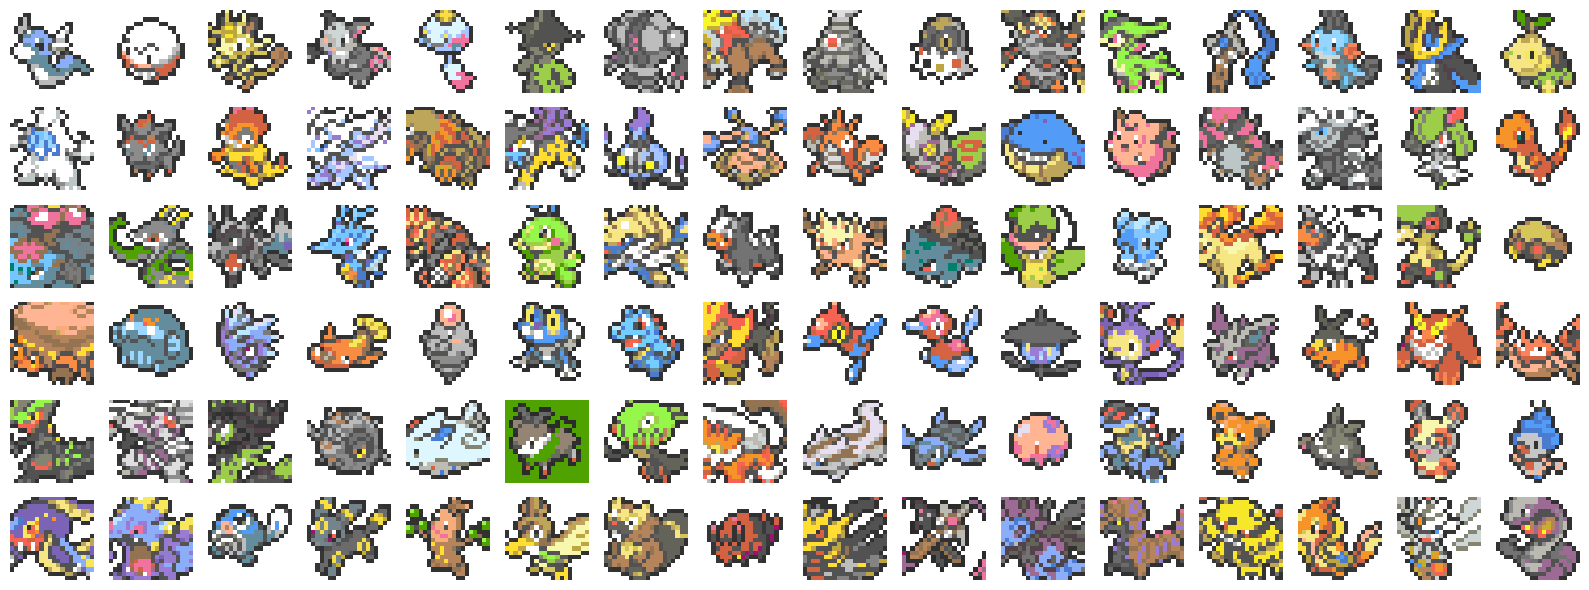

In [ ]:
# Visualize train images
train_images = [pixel_to_image(data["pixel_color"], colormap) for data in pokemon_dataset["train"]]
show_images(train_images)

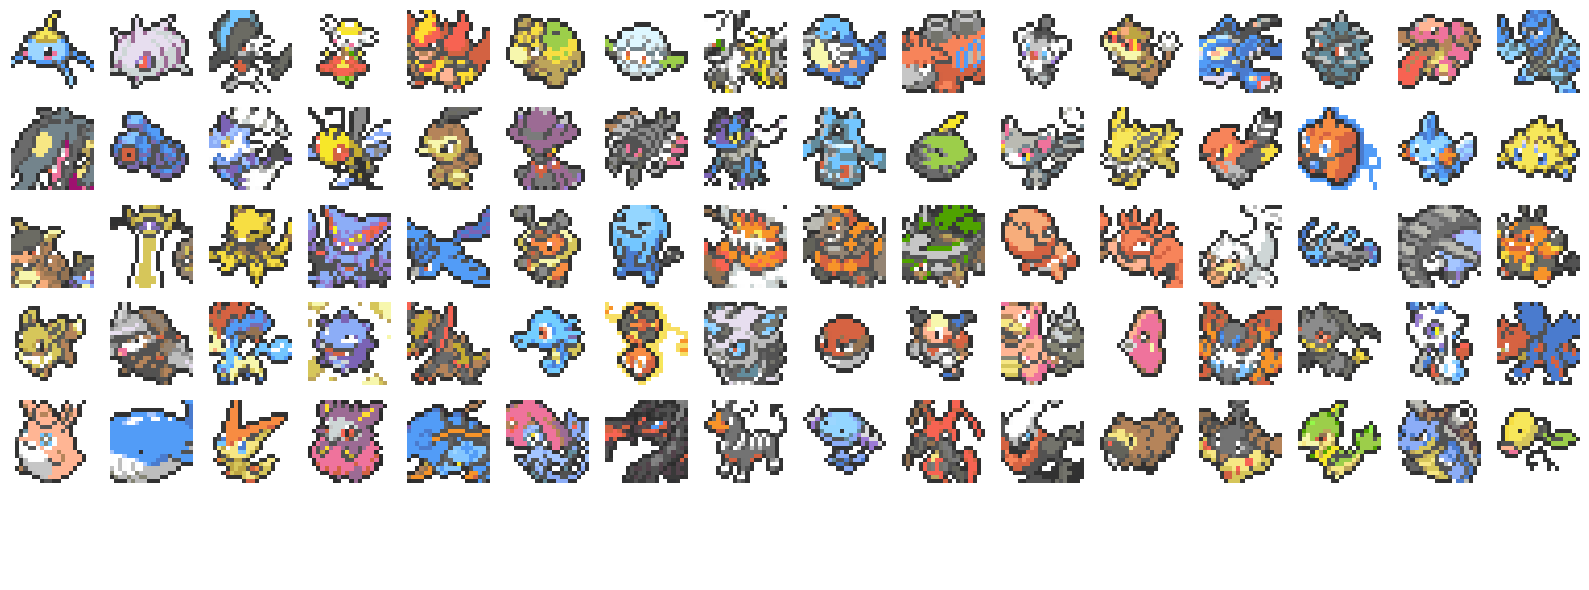

In [ ]:
dev_images = [pixel_to_image(data["pixel_color"], colormap) for data in pokemon_dataset["dev"]]
show_images(dev_images)

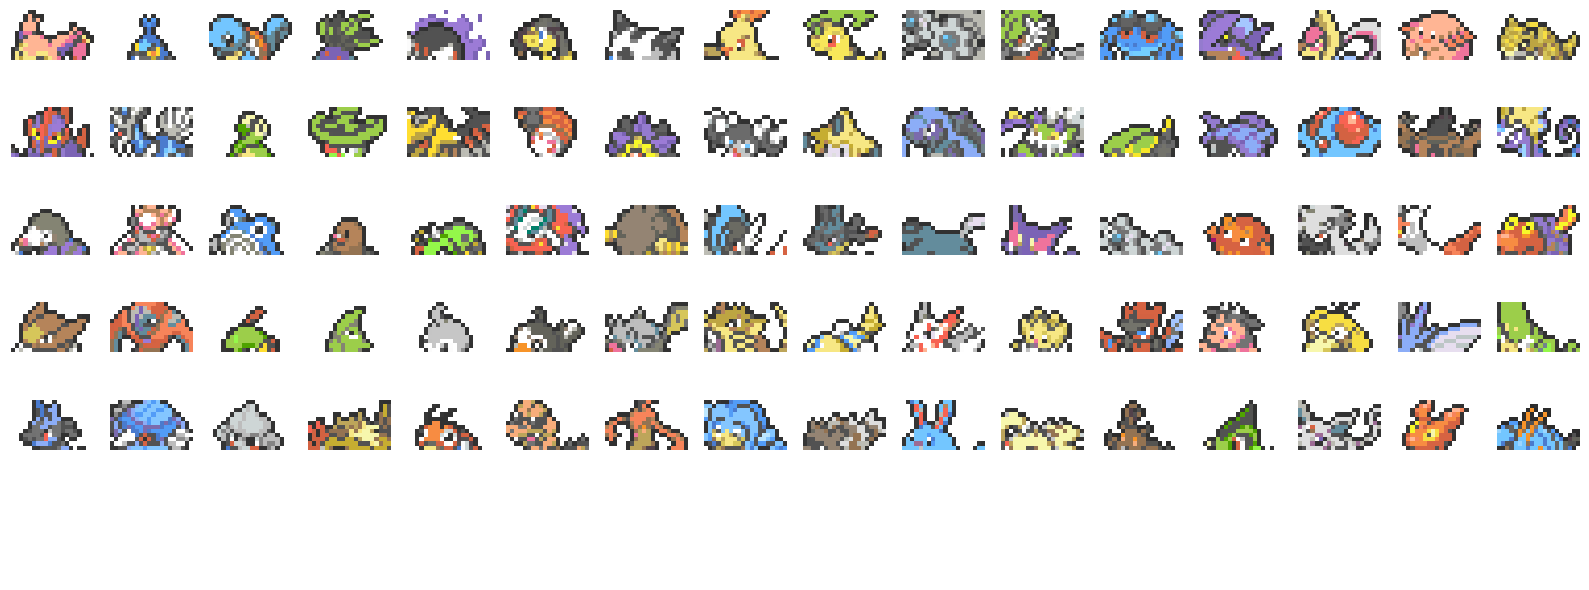

In [ ]:
# Visualize test images
test_images = [pixel_to_image(data["pixel_color"], colormap) for data in pokemon_dataset["test"]]
show_images(test_images)

# Prepare Model

### Model Configuration
Here, we define the model configuration, including the architecture and key hyperparameters such as the number of attention heads, layers, embedding size, and more.
*   Hint 1: Adjust hyperparameters here for improved performance.
*   Hint 2: Experiment with different model architectures, such as Llama, Mistral, or Qwen, to enhance performance.
  * [LlamaConfig](https://huggingface.co/docs/transformers/model_doc/llama#transformers.LlamaConfig)
  * [MistralConfig](https://huggingface.co/docs/transformers/model_doc/mistral#transformers.MistralConfig)
  * [Qwen2Config](https://huggingface.co/docs/transformers/model_doc/qwen2#transformers.Qwen2Config)


In [ ]:
llama_config_scaled = {
    "architectures": ["LlamaForCausalLM"],
    "hidden_size": 256,
    "num_hidden_layers": 4,
    "num_attention_heads": 4,
    "intermediate_size": 1024,
    "max_position_embeddings": 512,
    "vocab_size": num_classes,
    "attention_dropout": 0.1,
    "hidden_dropout": 0.1,
    "rms_norm_eps": 1e-05,
    "initializer_range": 0.02,
    "model_type": "llama",
    "activation_function": "silu",
    "use_cache": True,
    "rope_scaling": None,
    "pad_token_id": None,
    "eos_token_id": None,
}
from transformers import LlamaConfig
config = LlamaConfig.from_dict(llama_config_scaled)

### Load Model

In [ ]:
# Load the model using the configuration defined above
model = AutoModelForCausalLM.from_config(config)

print(model)

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable Parameters: {trainable_params:,}")

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(167, 256)
    (layers): ModuleList(
      (0-3): 4 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=256, out_features=256, bias=False)
          (k_proj): Linear(in_features=256, out_features=256, bias=False)
          (v_proj): Linear(in_features=256, out_features=256, bias=False)
          (o_proj): Linear(in_features=256, out_features=256, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=256, out_features=1024, bias=False)
          (up_proj): Linear(in_features=256, out_features=1024, bias=False)
          (down_proj): Linear(in_features=1024, out_features=256, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((256,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((256,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((256,), eps=1e-05)
    (rotary_emb): LlamaRotaryEmbedd

# Train and Inference

### Training Arguments
Here, we define the number of epochs for training, the learning rate, the optimizer, and the loss function.
*   Hint 3: Adjust the number of epochs and learning rate here to improve performance.

In [ ]:
# Training Parameters
epochs = 100                                     # Number of training epochs
learning_rate = 2e-4                          # Learning rate for optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")     # Check if CUDA is available for GPU
save_dir = "checkpoints"                               # Directory to save model checkpoints

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()                          # Loss function for classification tasks
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.1) # AdamW optimizer with weight decay

### Save Model Function

In [ ]:
def save_model(model: torch.nn.Module, optimizer: torch.optim.Optimizer, epoch: int, loss: float, save_dir: str, filename: str = "best_model.pth") -> None:
    """
    Saves the model state, optimizer state, current epoch, and loss to a specified directory.

    Args:
        model (torch.nn.Module): The PyTorch model to be saved.
        optimizer (torch.optim.Optimizer): The optimizer whose state will be saved.
        epoch (int): The current epoch number (used for checkpointing).
        loss (float): The current loss value to track model performance.
        save_dir (str): The directory where the model checkpoint will be saved.
        filename (str, optional): The name of the file to save the model. Defaults to "best_model.pth".

    Returns:
        None
    """
    # Construct the full path for saving the model checkpoint
    save_path = os.path.join(save_dir, filename)

    # Save the model, optimizer state, and additional metadata (epoch and loss)
    torch.save({
        'epoch': epoch + 1,                # Save epoch + 1 for easier tracking
        'model_state_dict': model.state_dict(),       # Save model weights
        'optimizer_state_dict': optimizer.state_dict(),  # Save optimizer state (important for resuming training)
        'loss': loss                     # Save the current loss value
    }, save_path)

    # Print a confirmation message indicating the model has been saved
    print(f"Model saved at {save_path} (Loss: {loss:.4f}, Epoch: {epoch + 1})")

### Train

We save the checkpoint with the lowest training loss since validation set reconstruction accuracy doesn't directly reflect the model's image generation quality.
*   Hint 4: Train a classifier to check if an image looks like a Pokémon or not. (Optional)

In [ ]:
# Create save directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)
# Initialize best loss as positive infinity for comparison during model checkpointing
best_loss: float = float('inf')
# Move model to the appropriate device (GPU or CPU)
model.to(device)

# Training Loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0  # Initialize the epoch loss

    # Iterate over training data batches
    for input_ids, labels in tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
        input_ids, labels = input_ids.to(device), labels.to(device)  # Move data to the same device as the model

        # Forward pass through the model to get logits (output probabilities)
        outputs = model(input_ids=input_ids).logits.view(-1, config.vocab_size)
        labels = labels.view(-1)  # Flatten labels to match logits shape

        # Calculate loss using CrossEntropyLoss
        loss = criterion(outputs, labels)

        # Backpropagation and optimizer step
        optimizer.zero_grad()  # Reset gradients to zero
        loss.backward()     # Compute gradients
        optimizer.step()     # Update model weights

        # Accumulate the loss for the epoch
        epoch_loss += loss.item()

    # Compute average epoch loss
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_epoch_loss:.4f}")

    # Evaluation Loop (Validation)
    model.eval()      # Set the model to evaluation mode (disables dropout, etc.)
    total_accuracy = 0  # Initialize total accuracy
    val_loss = 0      # Initialize validation loss
    num_batches = 0   # Initialize batch counter

    with torch.no_grad():  # Disable gradient calculation for validation
        # Iterate over validation data batches
        for inputs, labels in tqdm(dev_dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)  # Move validation data to device
            attention_mask = torch.ones_like(inputs)          # Attention mask to ensure valid token positions

            outputs = model(input_ids=inputs).logits  # Shape: [batch_size, seq_len, vocab_size]
            batch_size, seq_len, vocab_size = outputs.shape
            outputs = outputs.view(-1, vocab_size)    # Shape: [batch_size * seq_len, vocab_size]
            labels_flat = labels.view(-1)             # Shape: [batch_size * seq_len]

            # Calculate validation loss
            if outputs.shape[0] != labels_flat.shape[0]:
                min_size = min(outputs.shape[0], labels_flat.shape[0])
                outputs = outputs[:min_size]
                labels_flat = labels_flat[:min_size]
            loss = criterion(outputs, labels_flat)
            val_loss += loss.item()

            # Perform batch inference for accuracy
            generated_outputs = model.generate(inputs, attention_mask=attention_mask, max_length=400)
            generated_outputs = generated_outputs[:, -160:]  # Extract last 160 tokens

            # Calculate accuracy (ensure shapes match)
            labels_acc = labels.view(generated_outputs.shape)
            accuracy = (generated_outputs == labels_acc).float().mean().item()
            total_accuracy += accuracy
            num_batches += 1

    # Compute average validation loss and accuracy
    avg_val_loss = val_loss / num_batches
    avg_accuracy = total_accuracy / num_batches
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_epoch_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Reconstruction Accuracy: {avg_accuracy:.4f}")

    # If the current epoch loss is better (lower) than the best loss, save the model
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss                   # Update best loss
        save_model(model, optimizer, epoch, best_loss, save_dir)  # Save the model with the best loss

Training Epoch 1/100: 100%|██████████| 40/40 [00:03<00:00, 12.34it/s]


Epoch 1/100, Loss: 1.2533


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Epoch 1/100, Train Loss: 1.2533, Val Loss: 6.3402, Reconstruction Accuracy: 0.3610
Model saved at checkpoints/best_model.pth (Loss: 1.2533, Epoch: 1)


Training Epoch 2/100: 100%|██████████| 40/40 [00:03<00:00, 12.47it/s]


Epoch 2/100, Loss: 1.2121


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 2/100, Train Loss: 1.2121, Val Loss: 6.2784, Reconstruction Accuracy: 0.3702
Model saved at checkpoints/best_model.pth (Loss: 1.2121, Epoch: 2)


Training Epoch 3/100: 100%|██████████| 40/40 [00:03<00:00, 12.51it/s]


Epoch 3/100, Loss: 1.1875


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Epoch 3/100, Train Loss: 1.1875, Val Loss: 6.4295, Reconstruction Accuracy: 0.3526
Model saved at checkpoints/best_model.pth (Loss: 1.1875, Epoch: 3)


Training Epoch 4/100: 100%|██████████| 40/40 [00:03<00:00, 12.49it/s]


Epoch 4/100, Loss: 1.1611


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch 4/100, Train Loss: 1.1611, Val Loss: 6.4780, Reconstruction Accuracy: 0.3483
Model saved at checkpoints/best_model.pth (Loss: 1.1611, Epoch: 4)


Training Epoch 5/100: 100%|██████████| 40/40 [00:03<00:00, 12.51it/s]


Epoch 5/100, Loss: 1.1397


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 5/100, Train Loss: 1.1397, Val Loss: 6.5052, Reconstruction Accuracy: 0.3802
Model saved at checkpoints/best_model.pth (Loss: 1.1397, Epoch: 5)


Training Epoch 6/100: 100%|██████████| 40/40 [00:03<00:00, 12.57it/s]


Epoch 6/100, Loss: 1.1186


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 6/100, Train Loss: 1.1186, Val Loss: 6.5308, Reconstruction Accuracy: 0.3602
Model saved at checkpoints/best_model.pth (Loss: 1.1186, Epoch: 6)


Training Epoch 7/100: 100%|██████████| 40/40 [00:03<00:00, 12.54it/s]


Epoch 7/100, Loss: 1.0974


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 7/100, Train Loss: 1.0974, Val Loss: 6.6051, Reconstruction Accuracy: 0.3867
Model saved at checkpoints/best_model.pth (Loss: 1.0974, Epoch: 7)


Training Epoch 8/100: 100%|██████████| 40/40 [00:03<00:00, 12.47it/s]


Epoch 8/100, Loss: 1.0729


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 8/100, Train Loss: 1.0729, Val Loss: 6.5026, Reconstruction Accuracy: 0.3791
Model saved at checkpoints/best_model.pth (Loss: 1.0729, Epoch: 8)


Training Epoch 9/100: 100%|██████████| 40/40 [00:03<00:00, 12.55it/s]


Epoch 9/100, Loss: 1.0431


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 9/100, Train Loss: 1.0431, Val Loss: 6.6691, Reconstruction Accuracy: 0.3595
Model saved at checkpoints/best_model.pth (Loss: 1.0431, Epoch: 9)


Training Epoch 10/100: 100%|██████████| 40/40 [00:03<00:00, 12.59it/s]


Epoch 10/100, Loss: 1.0194


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 10/100, Train Loss: 1.0194, Val Loss: 6.7280, Reconstruction Accuracy: 0.3564
Model saved at checkpoints/best_model.pth (Loss: 1.0194, Epoch: 10)


Training Epoch 11/100: 100%|██████████| 40/40 [00:03<00:00, 12.49it/s]


Epoch 11/100, Loss: 0.9939


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 11/100, Train Loss: 0.9939, Val Loss: 6.7680, Reconstruction Accuracy: 0.3605
Model saved at checkpoints/best_model.pth (Loss: 0.9939, Epoch: 11)


Training Epoch 12/100: 100%|██████████| 40/40 [00:03<00:00, 12.53it/s]


Epoch 12/100, Loss: 0.9743


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 12/100, Train Loss: 0.9743, Val Loss: 6.7968, Reconstruction Accuracy: 0.3592
Model saved at checkpoints/best_model.pth (Loss: 0.9743, Epoch: 12)


Training Epoch 13/100: 100%|██████████| 40/40 [00:03<00:00, 12.50it/s]


Epoch 13/100, Loss: 0.9428


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 13/100, Train Loss: 0.9428, Val Loss: 6.7601, Reconstruction Accuracy: 0.3710
Model saved at checkpoints/best_model.pth (Loss: 0.9428, Epoch: 13)


Training Epoch 14/100: 100%|██████████| 40/40 [00:03<00:00, 12.49it/s]


Epoch 14/100, Loss: 0.9190


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch 14/100, Train Loss: 0.9190, Val Loss: 6.8974, Reconstruction Accuracy: 0.3773
Model saved at checkpoints/best_model.pth (Loss: 0.9190, Epoch: 14)


Training Epoch 15/100: 100%|██████████| 40/40 [00:03<00:00, 12.53it/s]


Epoch 15/100, Loss: 0.8951


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch 15/100, Train Loss: 0.8951, Val Loss: 6.8962, Reconstruction Accuracy: 0.3655
Model saved at checkpoints/best_model.pth (Loss: 0.8951, Epoch: 15)


Training Epoch 16/100: 100%|██████████| 40/40 [00:03<00:00, 12.39it/s]


Epoch 16/100, Loss: 0.8710


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 16/100, Train Loss: 0.8710, Val Loss: 6.9812, Reconstruction Accuracy: 0.3780
Model saved at checkpoints/best_model.pth (Loss: 0.8710, Epoch: 16)


Training Epoch 17/100: 100%|██████████| 40/40 [00:03<00:00, 12.50it/s]


Epoch 17/100, Loss: 0.8447


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 17/100, Train Loss: 0.8447, Val Loss: 6.9540, Reconstruction Accuracy: 0.3728
Model saved at checkpoints/best_model.pth (Loss: 0.8447, Epoch: 17)


Training Epoch 18/100: 100%|██████████| 40/40 [00:03<00:00, 12.51it/s]


Epoch 18/100, Loss: 0.8100


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 18/100, Train Loss: 0.8100, Val Loss: 7.1550, Reconstruction Accuracy: 0.3672
Model saved at checkpoints/best_model.pth (Loss: 0.8100, Epoch: 18)


Training Epoch 19/100: 100%|██████████| 40/40 [00:03<00:00, 12.47it/s]


Epoch 19/100, Loss: 0.7753


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 19/100, Train Loss: 0.7753, Val Loss: 7.1479, Reconstruction Accuracy: 0.3926
Model saved at checkpoints/best_model.pth (Loss: 0.7753, Epoch: 19)


Training Epoch 20/100: 100%|██████████| 40/40 [00:03<00:00, 12.51it/s]


Epoch 20/100, Loss: 0.7471


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 20/100, Train Loss: 0.7471, Val Loss: 7.1999, Reconstruction Accuracy: 0.3872
Model saved at checkpoints/best_model.pth (Loss: 0.7471, Epoch: 20)


Training Epoch 21/100: 100%|██████████| 40/40 [00:03<00:00, 12.52it/s]


Epoch 21/100, Loss: 0.7150


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 21/100, Train Loss: 0.7150, Val Loss: 7.2799, Reconstruction Accuracy: 0.3661
Model saved at checkpoints/best_model.pth (Loss: 0.7150, Epoch: 21)


Training Epoch 22/100: 100%|██████████| 40/40 [00:03<00:00, 12.51it/s]


Epoch 22/100, Loss: 0.6935


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 22/100, Train Loss: 0.6935, Val Loss: 7.3745, Reconstruction Accuracy: 0.3655
Model saved at checkpoints/best_model.pth (Loss: 0.6935, Epoch: 22)


Training Epoch 23/100: 100%|██████████| 40/40 [00:03<00:00, 12.53it/s]


Epoch 23/100, Loss: 0.6718


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Epoch 23/100, Train Loss: 0.6718, Val Loss: 7.3403, Reconstruction Accuracy: 0.3688
Model saved at checkpoints/best_model.pth (Loss: 0.6718, Epoch: 23)


Training Epoch 24/100: 100%|██████████| 40/40 [00:03<00:00, 12.51it/s]


Epoch 24/100, Loss: 0.6471


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 24/100, Train Loss: 0.6471, Val Loss: 7.4396, Reconstruction Accuracy: 0.3791
Model saved at checkpoints/best_model.pth (Loss: 0.6471, Epoch: 24)


Training Epoch 25/100: 100%|██████████| 40/40 [00:03<00:00, 12.51it/s]


Epoch 25/100, Loss: 0.6211


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 25/100, Train Loss: 0.6211, Val Loss: 7.5082, Reconstruction Accuracy: 0.3667
Model saved at checkpoints/best_model.pth (Loss: 0.6211, Epoch: 25)


Training Epoch 26/100: 100%|██████████| 40/40 [00:03<00:00, 12.55it/s]


Epoch 26/100, Loss: 0.5943


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 26/100, Train Loss: 0.5943, Val Loss: 7.5401, Reconstruction Accuracy: 0.3559
Model saved at checkpoints/best_model.pth (Loss: 0.5943, Epoch: 26)


Training Epoch 27/100: 100%|██████████| 40/40 [00:03<00:00, 12.52it/s]


Epoch 27/100, Loss: 0.5739


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 27/100, Train Loss: 0.5739, Val Loss: 7.6290, Reconstruction Accuracy: 0.3755
Model saved at checkpoints/best_model.pth (Loss: 0.5739, Epoch: 27)


Training Epoch 28/100: 100%|██████████| 40/40 [00:03<00:00, 12.49it/s]


Epoch 28/100, Loss: 0.5540


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Epoch 28/100, Train Loss: 0.5540, Val Loss: 7.7059, Reconstruction Accuracy: 0.3553
Model saved at checkpoints/best_model.pth (Loss: 0.5540, Epoch: 28)


Training Epoch 29/100: 100%|██████████| 40/40 [00:03<00:00, 12.53it/s]


Epoch 29/100, Loss: 0.5304


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch 29/100, Train Loss: 0.5304, Val Loss: 7.7481, Reconstruction Accuracy: 0.3540
Model saved at checkpoints/best_model.pth (Loss: 0.5304, Epoch: 29)


Training Epoch 30/100: 100%|██████████| 40/40 [00:03<00:00, 12.50it/s]


Epoch 30/100, Loss: 0.5082


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 30/100, Train Loss: 0.5082, Val Loss: 7.9021, Reconstruction Accuracy: 0.3690
Model saved at checkpoints/best_model.pth (Loss: 0.5082, Epoch: 30)


Training Epoch 31/100: 100%|██████████| 40/40 [00:03<00:00, 12.56it/s]


Epoch 31/100, Loss: 0.4770


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 31/100, Train Loss: 0.4770, Val Loss: 7.9294, Reconstruction Accuracy: 0.3595
Model saved at checkpoints/best_model.pth (Loss: 0.4770, Epoch: 31)


Training Epoch 32/100: 100%|██████████| 40/40 [00:03<00:00, 12.51it/s]


Epoch 32/100, Loss: 0.4556


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch 32/100, Train Loss: 0.4556, Val Loss: 8.0207, Reconstruction Accuracy: 0.3755
Model saved at checkpoints/best_model.pth (Loss: 0.4556, Epoch: 32)


Training Epoch 33/100: 100%|██████████| 40/40 [00:03<00:00, 12.45it/s]


Epoch 33/100, Loss: 0.4395


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 33/100, Train Loss: 0.4395, Val Loss: 8.0540, Reconstruction Accuracy: 0.3574
Model saved at checkpoints/best_model.pth (Loss: 0.4395, Epoch: 33)


Training Epoch 34/100: 100%|██████████| 40/40 [00:03<00:00, 12.53it/s]


Epoch 34/100, Loss: 0.4250


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 34/100, Train Loss: 0.4250, Val Loss: 8.1294, Reconstruction Accuracy: 0.3577
Model saved at checkpoints/best_model.pth (Loss: 0.4250, Epoch: 34)


Training Epoch 35/100: 100%|██████████| 40/40 [00:03<00:00, 12.52it/s]


Epoch 35/100, Loss: 0.4121


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 35/100, Train Loss: 0.4121, Val Loss: 8.2153, Reconstruction Accuracy: 0.3651
Model saved at checkpoints/best_model.pth (Loss: 0.4121, Epoch: 35)


Training Epoch 36/100: 100%|██████████| 40/40 [00:03<00:00, 12.51it/s]


Epoch 36/100, Loss: 0.3903


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 36/100, Train Loss: 0.3903, Val Loss: 8.3071, Reconstruction Accuracy: 0.3467
Model saved at checkpoints/best_model.pth (Loss: 0.3903, Epoch: 36)


Training Epoch 37/100: 100%|██████████| 40/40 [00:03<00:00, 12.52it/s]


Epoch 37/100, Loss: 0.3657


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 37/100, Train Loss: 0.3657, Val Loss: 8.3379, Reconstruction Accuracy: 0.3498
Model saved at checkpoints/best_model.pth (Loss: 0.3657, Epoch: 37)


Training Epoch 38/100: 100%|██████████| 40/40 [00:03<00:00, 12.50it/s]


Epoch 38/100, Loss: 0.3561


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 38/100, Train Loss: 0.3561, Val Loss: 8.4717, Reconstruction Accuracy: 0.3493
Model saved at checkpoints/best_model.pth (Loss: 0.3561, Epoch: 38)


Training Epoch 39/100: 100%|██████████| 40/40 [00:03<00:00, 12.47it/s]


Epoch 39/100, Loss: 0.3495


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch 39/100, Train Loss: 0.3495, Val Loss: 8.4601, Reconstruction Accuracy: 0.3698
Model saved at checkpoints/best_model.pth (Loss: 0.3495, Epoch: 39)


Training Epoch 40/100: 100%|██████████| 40/40 [00:03<00:00, 12.56it/s]


Epoch 40/100, Loss: 0.3352


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 40/100, Train Loss: 0.3352, Val Loss: 8.5938, Reconstruction Accuracy: 0.3770
Model saved at checkpoints/best_model.pth (Loss: 0.3352, Epoch: 40)


Training Epoch 41/100: 100%|██████████| 40/40 [00:03<00:00, 12.47it/s]


Epoch 41/100, Loss: 0.3238


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 41/100, Train Loss: 0.3238, Val Loss: 8.5798, Reconstruction Accuracy: 0.3652
Model saved at checkpoints/best_model.pth (Loss: 0.3238, Epoch: 41)


Training Epoch 42/100: 100%|██████████| 40/40 [00:03<00:00, 12.49it/s]


Epoch 42/100, Loss: 0.3086


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Epoch 42/100, Train Loss: 0.3086, Val Loss: 8.6709, Reconstruction Accuracy: 0.3690
Model saved at checkpoints/best_model.pth (Loss: 0.3086, Epoch: 42)


Training Epoch 43/100: 100%|██████████| 40/40 [00:03<00:00, 12.56it/s]


Epoch 43/100, Loss: 0.2991


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Epoch 43/100, Train Loss: 0.2991, Val Loss: 8.7335, Reconstruction Accuracy: 0.3368
Model saved at checkpoints/best_model.pth (Loss: 0.2991, Epoch: 43)


Training Epoch 44/100: 100%|██████████| 40/40 [00:03<00:00, 12.55it/s]


Epoch 44/100, Loss: 0.2877


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 44/100, Train Loss: 0.2877, Val Loss: 8.7362, Reconstruction Accuracy: 0.3682
Model saved at checkpoints/best_model.pth (Loss: 0.2877, Epoch: 44)


Training Epoch 45/100: 100%|██████████| 40/40 [00:03<00:00, 12.53it/s]


Epoch 45/100, Loss: 0.2811


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 45/100, Train Loss: 0.2811, Val Loss: 8.8485, Reconstruction Accuracy: 0.3442
Model saved at checkpoints/best_model.pth (Loss: 0.2811, Epoch: 45)


Training Epoch 46/100: 100%|██████████| 40/40 [00:03<00:00, 12.60it/s]


Epoch 46/100, Loss: 0.2677


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 46/100, Train Loss: 0.2677, Val Loss: 8.9289, Reconstruction Accuracy: 0.3659
Model saved at checkpoints/best_model.pth (Loss: 0.2677, Epoch: 46)


Training Epoch 47/100: 100%|██████████| 40/40 [00:03<00:00, 12.53it/s]


Epoch 47/100, Loss: 0.2584


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 47/100, Train Loss: 0.2584, Val Loss: 8.8979, Reconstruction Accuracy: 0.3598
Model saved at checkpoints/best_model.pth (Loss: 0.2584, Epoch: 47)


Training Epoch 48/100: 100%|██████████| 40/40 [00:03<00:00, 12.49it/s]


Epoch 48/100, Loss: 0.2450


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 48/100, Train Loss: 0.2450, Val Loss: 8.9772, Reconstruction Accuracy: 0.3532
Model saved at checkpoints/best_model.pth (Loss: 0.2450, Epoch: 48)


Training Epoch 49/100: 100%|██████████| 40/40 [00:03<00:00, 12.51it/s]


Epoch 49/100, Loss: 0.2382


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 49/100, Train Loss: 0.2382, Val Loss: 8.9890, Reconstruction Accuracy: 0.3595
Model saved at checkpoints/best_model.pth (Loss: 0.2382, Epoch: 49)


Training Epoch 50/100: 100%|██████████| 40/40 [00:03<00:00, 12.49it/s]


Epoch 50/100, Loss: 0.2325


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 50/100, Train Loss: 0.2325, Val Loss: 9.0581, Reconstruction Accuracy: 0.3568
Model saved at checkpoints/best_model.pth (Loss: 0.2325, Epoch: 50)


Training Epoch 51/100: 100%|██████████| 40/40 [00:03<00:00, 12.55it/s]


Epoch 51/100, Loss: 0.2288


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 51/100, Train Loss: 0.2288, Val Loss: 9.1631, Reconstruction Accuracy: 0.3648
Model saved at checkpoints/best_model.pth (Loss: 0.2288, Epoch: 51)


Training Epoch 52/100: 100%|██████████| 40/40 [00:03<00:00, 12.54it/s]


Epoch 52/100, Loss: 0.2227


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 52/100, Train Loss: 0.2227, Val Loss: 9.2326, Reconstruction Accuracy: 0.3556
Model saved at checkpoints/best_model.pth (Loss: 0.2227, Epoch: 52)


Training Epoch 53/100: 100%|██████████| 40/40 [00:03<00:00, 12.45it/s]


Epoch 53/100, Loss: 0.2158


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch 53/100, Train Loss: 0.2158, Val Loss: 9.2787, Reconstruction Accuracy: 0.3584
Model saved at checkpoints/best_model.pth (Loss: 0.2158, Epoch: 53)


Training Epoch 54/100: 100%|██████████| 40/40 [00:03<00:00, 12.55it/s]


Epoch 54/100, Loss: 0.2062


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Epoch 54/100, Train Loss: 0.2062, Val Loss: 9.2772, Reconstruction Accuracy: 0.3552
Model saved at checkpoints/best_model.pth (Loss: 0.2062, Epoch: 54)


Training Epoch 55/100: 100%|██████████| 40/40 [00:03<00:00, 12.56it/s]


Epoch 55/100, Loss: 0.1963


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 55/100, Train Loss: 0.1963, Val Loss: 9.2237, Reconstruction Accuracy: 0.3588
Model saved at checkpoints/best_model.pth (Loss: 0.1963, Epoch: 55)


Training Epoch 56/100: 100%|██████████| 40/40 [00:03<00:00, 12.53it/s]


Epoch 56/100, Loss: 0.1921


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Epoch 56/100, Train Loss: 0.1921, Val Loss: 9.4026, Reconstruction Accuracy: 0.3584
Model saved at checkpoints/best_model.pth (Loss: 0.1921, Epoch: 56)


Training Epoch 57/100: 100%|██████████| 40/40 [00:03<00:00, 12.55it/s]


Epoch 57/100, Loss: 0.1838


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch 57/100, Train Loss: 0.1838, Val Loss: 9.3770, Reconstruction Accuracy: 0.3670
Model saved at checkpoints/best_model.pth (Loss: 0.1838, Epoch: 57)


Training Epoch 58/100: 100%|██████████| 40/40 [00:03<00:00, 12.48it/s]


Epoch 58/100, Loss: 0.1785


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 58/100, Train Loss: 0.1785, Val Loss: 9.4060, Reconstruction Accuracy: 0.3687
Model saved at checkpoints/best_model.pth (Loss: 0.1785, Epoch: 58)


Training Epoch 59/100: 100%|██████████| 40/40 [00:03<00:00, 12.50it/s]


Epoch 59/100, Loss: 0.1734


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 59/100, Train Loss: 0.1734, Val Loss: 9.5179, Reconstruction Accuracy: 0.3630
Model saved at checkpoints/best_model.pth (Loss: 0.1734, Epoch: 59)


Training Epoch 60/100: 100%|██████████| 40/40 [00:03<00:00, 12.50it/s]


Epoch 60/100, Loss: 0.1697


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 60/100, Train Loss: 0.1697, Val Loss: 9.5740, Reconstruction Accuracy: 0.3799
Model saved at checkpoints/best_model.pth (Loss: 0.1697, Epoch: 60)


Training Epoch 61/100: 100%|██████████| 40/40 [00:03<00:00, 12.50it/s]


Epoch 61/100, Loss: 0.1679


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 61/100, Train Loss: 0.1679, Val Loss: 9.5602, Reconstruction Accuracy: 0.3747
Model saved at checkpoints/best_model.pth (Loss: 0.1679, Epoch: 61)


Training Epoch 62/100: 100%|██████████| 40/40 [00:03<00:00, 12.56it/s]


Epoch 62/100, Loss: 0.1668


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Epoch 62/100, Train Loss: 0.1668, Val Loss: 9.5576, Reconstruction Accuracy: 0.3615
Model saved at checkpoints/best_model.pth (Loss: 0.1668, Epoch: 62)


Training Epoch 63/100: 100%|██████████| 40/40 [00:03<00:00, 12.50it/s]


Epoch 63/100, Loss: 0.1617


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 63/100, Train Loss: 0.1617, Val Loss: 9.7140, Reconstruction Accuracy: 0.3552
Model saved at checkpoints/best_model.pth (Loss: 0.1617, Epoch: 63)


Training Epoch 64/100: 100%|██████████| 40/40 [00:03<00:00, 12.52it/s]


Epoch 64/100, Loss: 0.1580


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 64/100, Train Loss: 0.1580, Val Loss: 9.7197, Reconstruction Accuracy: 0.3684
Model saved at checkpoints/best_model.pth (Loss: 0.1580, Epoch: 64)


Training Epoch 65/100: 100%|██████████| 40/40 [00:03<00:00, 12.57it/s]


Epoch 65/100, Loss: 0.1537


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 65/100, Train Loss: 0.1537, Val Loss: 9.7324, Reconstruction Accuracy: 0.3602
Model saved at checkpoints/best_model.pth (Loss: 0.1537, Epoch: 65)


Training Epoch 66/100: 100%|██████████| 40/40 [00:03<00:00, 12.53it/s]


Epoch 66/100, Loss: 0.1472


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 66/100, Train Loss: 0.1472, Val Loss: 9.7915, Reconstruction Accuracy: 0.3713
Model saved at checkpoints/best_model.pth (Loss: 0.1472, Epoch: 66)


Training Epoch 67/100: 100%|██████████| 40/40 [00:03<00:00, 12.46it/s]


Epoch 67/100, Loss: 0.1487


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch 67/100, Train Loss: 0.1487, Val Loss: 9.7784, Reconstruction Accuracy: 0.3660


Training Epoch 68/100: 100%|██████████| 40/40 [00:03<00:00, 12.49it/s]


Epoch 68/100, Loss: 0.1466


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch 68/100, Train Loss: 0.1466, Val Loss: 9.9150, Reconstruction Accuracy: 0.3700
Model saved at checkpoints/best_model.pth (Loss: 0.1466, Epoch: 68)


Training Epoch 69/100: 100%|██████████| 40/40 [00:03<00:00, 12.42it/s]


Epoch 69/100, Loss: 0.1425


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 69/100, Train Loss: 0.1425, Val Loss: 9.8408, Reconstruction Accuracy: 0.3600
Model saved at checkpoints/best_model.pth (Loss: 0.1425, Epoch: 69)


Training Epoch 70/100: 100%|██████████| 40/40 [00:03<00:00, 12.48it/s]


Epoch 70/100, Loss: 0.1389


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 70/100, Train Loss: 0.1389, Val Loss: 9.7896, Reconstruction Accuracy: 0.3461
Model saved at checkpoints/best_model.pth (Loss: 0.1389, Epoch: 70)


Training Epoch 71/100: 100%|██████████| 40/40 [00:03<00:00, 12.56it/s]


Epoch 71/100, Loss: 0.1401


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 71/100, Train Loss: 0.1401, Val Loss: 9.9508, Reconstruction Accuracy: 0.3609


Training Epoch 72/100: 100%|██████████| 40/40 [00:03<00:00, 12.55it/s]


Epoch 72/100, Loss: 0.1312


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 72/100, Train Loss: 0.1312, Val Loss: 9.9436, Reconstruction Accuracy: 0.3683
Model saved at checkpoints/best_model.pth (Loss: 0.1312, Epoch: 72)


Training Epoch 73/100: 100%|██████████| 40/40 [00:03<00:00, 12.58it/s]


Epoch 73/100, Loss: 0.1264


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 73/100, Train Loss: 0.1264, Val Loss: 9.9942, Reconstruction Accuracy: 0.3568
Model saved at checkpoints/best_model.pth (Loss: 0.1264, Epoch: 73)


Training Epoch 74/100: 100%|██████████| 40/40 [00:03<00:00, 12.61it/s]


Epoch 74/100, Loss: 0.1269


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 74/100, Train Loss: 0.1269, Val Loss: 10.0499, Reconstruction Accuracy: 0.3556


Training Epoch 75/100: 100%|██████████| 40/40 [00:03<00:00, 12.47it/s]


Epoch 75/100, Loss: 0.1274


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 75/100, Train Loss: 0.1274, Val Loss: 10.0222, Reconstruction Accuracy: 0.3793


Training Epoch 76/100: 100%|██████████| 40/40 [00:03<00:00, 12.52it/s]


Epoch 76/100, Loss: 0.1258


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 76/100, Train Loss: 0.1258, Val Loss: 10.0165, Reconstruction Accuracy: 0.3584
Model saved at checkpoints/best_model.pth (Loss: 0.1258, Epoch: 76)


Training Epoch 77/100: 100%|██████████| 40/40 [00:03<00:00, 12.55it/s]


Epoch 77/100, Loss: 0.1205


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 77/100, Train Loss: 0.1205, Val Loss: 10.0665, Reconstruction Accuracy: 0.3623
Model saved at checkpoints/best_model.pth (Loss: 0.1205, Epoch: 77)


Training Epoch 78/100: 100%|██████████| 40/40 [00:03<00:00, 12.48it/s]


Epoch 78/100, Loss: 0.1182


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch 78/100, Train Loss: 0.1182, Val Loss: 10.1452, Reconstruction Accuracy: 0.3613
Model saved at checkpoints/best_model.pth (Loss: 0.1182, Epoch: 78)


Training Epoch 79/100: 100%|██████████| 40/40 [00:03<00:00, 12.58it/s]


Epoch 79/100, Loss: 0.1146


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch 79/100, Train Loss: 0.1146, Val Loss: 10.1695, Reconstruction Accuracy: 0.3635
Model saved at checkpoints/best_model.pth (Loss: 0.1146, Epoch: 79)


Training Epoch 80/100: 100%|██████████| 40/40 [00:03<00:00, 12.47it/s]


Epoch 80/100, Loss: 0.1123


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 80/100, Train Loss: 0.1123, Val Loss: 10.1375, Reconstruction Accuracy: 0.3648
Model saved at checkpoints/best_model.pth (Loss: 0.1123, Epoch: 80)


Training Epoch 81/100: 100%|██████████| 40/40 [00:03<00:00, 12.56it/s]


Epoch 81/100, Loss: 0.1113


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 81/100, Train Loss: 0.1113, Val Loss: 10.2616, Reconstruction Accuracy: 0.3727
Model saved at checkpoints/best_model.pth (Loss: 0.1113, Epoch: 81)


Training Epoch 82/100: 100%|██████████| 40/40 [00:03<00:00, 12.54it/s]


Epoch 82/100, Loss: 0.1118


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 82/100, Train Loss: 0.1118, Val Loss: 10.3288, Reconstruction Accuracy: 0.3623


Training Epoch 83/100: 100%|██████████| 40/40 [00:03<00:00, 12.56it/s]


Epoch 83/100, Loss: 0.1104


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 83/100, Train Loss: 0.1104, Val Loss: 10.3001, Reconstruction Accuracy: 0.3587
Model saved at checkpoints/best_model.pth (Loss: 0.1104, Epoch: 83)


Training Epoch 84/100: 100%|██████████| 40/40 [00:03<00:00, 12.51it/s]


Epoch 84/100, Loss: 0.1079


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 84/100, Train Loss: 0.1079, Val Loss: 10.3178, Reconstruction Accuracy: 0.3502
Model saved at checkpoints/best_model.pth (Loss: 0.1079, Epoch: 84)


Training Epoch 85/100: 100%|██████████| 40/40 [00:03<00:00, 12.51it/s]


Epoch 85/100, Loss: 0.1090


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 85/100, Train Loss: 0.1090, Val Loss: 10.4016, Reconstruction Accuracy: 0.3597


Training Epoch 86/100: 100%|██████████| 40/40 [00:03<00:00, 12.48it/s]


Epoch 86/100, Loss: 0.1086


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 86/100, Train Loss: 0.1086, Val Loss: 10.2612, Reconstruction Accuracy: 0.3740


Training Epoch 87/100: 100%|██████████| 40/40 [00:03<00:00, 12.57it/s]


Epoch 87/100, Loss: 0.1072


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 87/100, Train Loss: 0.1072, Val Loss: 10.3747, Reconstruction Accuracy: 0.3654
Model saved at checkpoints/best_model.pth (Loss: 0.1072, Epoch: 87)


Training Epoch 88/100: 100%|██████████| 40/40 [00:03<00:00, 12.50it/s]


Epoch 88/100, Loss: 0.1065


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 88/100, Train Loss: 0.1065, Val Loss: 10.4114, Reconstruction Accuracy: 0.3491
Model saved at checkpoints/best_model.pth (Loss: 0.1065, Epoch: 88)


Training Epoch 89/100: 100%|██████████| 40/40 [00:03<00:00, 12.51it/s]


Epoch 89/100, Loss: 0.1008


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch 89/100, Train Loss: 0.1008, Val Loss: 10.4386, Reconstruction Accuracy: 0.3768
Model saved at checkpoints/best_model.pth (Loss: 0.1008, Epoch: 89)


Training Epoch 90/100: 100%|██████████| 40/40 [00:03<00:00, 12.59it/s]


Epoch 90/100, Loss: 0.0991


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Epoch 90/100, Train Loss: 0.0991, Val Loss: 10.5559, Reconstruction Accuracy: 0.3792
Model saved at checkpoints/best_model.pth (Loss: 0.0991, Epoch: 90)


Training Epoch 91/100: 100%|██████████| 40/40 [00:03<00:00, 12.51it/s]


Epoch 91/100, Loss: 0.0988


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 91/100, Train Loss: 0.0988, Val Loss: 10.4668, Reconstruction Accuracy: 0.3563
Model saved at checkpoints/best_model.pth (Loss: 0.0988, Epoch: 91)


Training Epoch 92/100: 100%|██████████| 40/40 [00:03<00:00, 12.52it/s]


Epoch 92/100, Loss: 0.0980


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Epoch 92/100, Train Loss: 0.0980, Val Loss: 10.5582, Reconstruction Accuracy: 0.3603
Model saved at checkpoints/best_model.pth (Loss: 0.0980, Epoch: 92)


Training Epoch 93/100: 100%|██████████| 40/40 [00:03<00:00, 12.53it/s]


Epoch 93/100, Loss: 0.0986


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch 93/100, Train Loss: 0.0986, Val Loss: 10.4897, Reconstruction Accuracy: 0.3608


Training Epoch 94/100: 100%|██████████| 40/40 [00:03<00:00, 12.52it/s]


Epoch 94/100, Loss: 0.0974


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch 94/100, Train Loss: 0.0974, Val Loss: 10.4539, Reconstruction Accuracy: 0.3607
Model saved at checkpoints/best_model.pth (Loss: 0.0974, Epoch: 94)


Training Epoch 95/100: 100%|██████████| 40/40 [00:03<00:00, 12.50it/s]


Epoch 95/100, Loss: 0.0966


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Epoch 95/100, Train Loss: 0.0966, Val Loss: 10.5613, Reconstruction Accuracy: 0.3598
Model saved at checkpoints/best_model.pth (Loss: 0.0966, Epoch: 95)


Training Epoch 96/100: 100%|██████████| 40/40 [00:03<00:00, 12.50it/s]


Epoch 96/100, Loss: 0.0966


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 96/100, Train Loss: 0.0966, Val Loss: 10.6973, Reconstruction Accuracy: 0.3540
Model saved at checkpoints/best_model.pth (Loss: 0.0966, Epoch: 96)


Training Epoch 97/100: 100%|██████████| 40/40 [00:03<00:00, 12.48it/s]


Epoch 97/100, Loss: 0.0936


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch 97/100, Train Loss: 0.0936, Val Loss: 10.6319, Reconstruction Accuracy: 0.3488
Model saved at checkpoints/best_model.pth (Loss: 0.0936, Epoch: 97)


Training Epoch 98/100: 100%|██████████| 40/40 [00:03<00:00, 12.52it/s]


Epoch 98/100, Loss: 0.0936


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 98/100, Train Loss: 0.0936, Val Loss: 10.6600, Reconstruction Accuracy: 0.3670


Training Epoch 99/100: 100%|██████████| 40/40 [00:03<00:00, 12.56it/s]


Epoch 99/100, Loss: 0.0931


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 99/100, Train Loss: 0.0931, Val Loss: 10.6896, Reconstruction Accuracy: 0.3493
Model saved at checkpoints/best_model.pth (Loss: 0.0931, Epoch: 99)


Training Epoch 100/100: 100%|██████████| 40/40 [00:03<00:00, 12.48it/s]


Epoch 100/100, Loss: 0.0886


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]

Epoch 100/100, Train Loss: 0.0886, Val Loss: 10.7255, Reconstruction Accuracy: 0.3580
Model saved at checkpoints/best_model.pth (Loss: 0.0886, Epoch: 100)


### Inference

In [ ]:
# Load the best model from the saved checkpoint
best_model_path = os.path.join(save_dir, "best_model.pth")              # Path to the best model checkpoint
checkpoint = torch.load(best_model_path, weights_only=True, map_location=device)  # Load checkpoint from the file
model.load_state_dict(checkpoint["model_state_dict"])                  # Load the model weights from checkpoint
model.eval()                                        # Set the model to evaluation mode (disables dropout, etc.)

# Testing Loop with Batch Inference
results: list = []  # List to store the generated sequences from the model

with torch.no_grad():  # Disable gradient calculations for inference
    # Iterate over test data in batches
    for inputs in tqdm(test_dataloader, desc="Generating Outputs"):
        inputs = inputs.to(device)         # Move model to the appropriate device (GPU or CPU)
        attention_mask = torch.ones_like(inputs)  # Attention mask (ensure valid token positions)

        # Generate predictions for the entire batch
        generated_outputs = model.generate(inputs, attention_mask=attention_mask, max_length=400)

        # Convert batch outputs to a list and append to results
        batch_results = generated_outputs.cpu().numpy().tolist()
        results.extend(batch_results)  # Extend the results list with batch results

# Save the results to a file
output_file: str = "reconstructed_results.txt"  # File to save the output sequences
with open(output_file, "w") as f:
    # Write each sequence to the file
    for seq in results:
        f.write(" ".join(map(str, seq)) + "\n")

print(f"Reconstructed results saved to {output_file}")  # Confirmation message

Generating Outputs: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]

Reconstructed results saved to reconstructed_results.txt


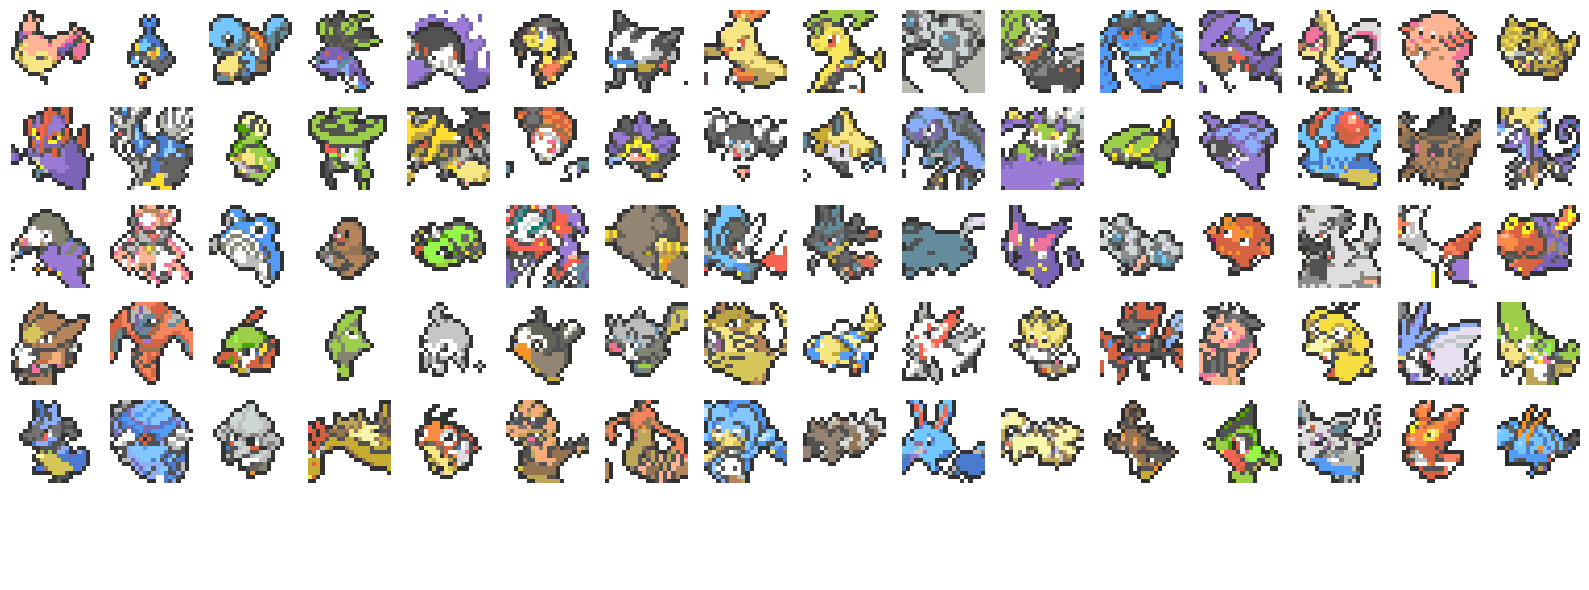

In [ ]:
# Visualize generated test images
predicted_images = [pixel_to_image(sequence, colormap) for sequence in results]
show_images(predicted_images)